In [4]:
%pip install pyspark

  Using cached pyspark-3.5.2-py2.py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pyspark

from pyspark.sql import SparkSession
from pyspark.sql.types import *

# Initialize a spark session
MAX_MEMORY = '15G'
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()

# Load data set into pyspark data frame 
filename_data = '../datasets/endomondoHR.json'
df = spark.read.json(filename_data, mode="DROPMALFORMED")
print('Data frame type: ' + str(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


In [4]:
import pandas as pd

print(f'Data overview:\n{df.printSchema()}')
print(f'Columns overview:\n{pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])}')

root
 |-- altitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- gender: string (nullable = true)
 |-- heart_rate: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- id: long (nullable = true)
 |-- latitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- longitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- speed: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- sport: string (nullable = true)
 |-- timestamp: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- url: string (nullable = true)
 |-- userId: long (nullable = true)

Data overview:
None
Columns overview:
   Column Name      Data type
0     altitude  array<double>
1       gender         string
2   heart_rate  array<bigint>
3           id         bigint
4     latitude  array<double>
5    longitude  array<double>
6        speed  array<double>
7        sport     

In [8]:
print(f'Data frame describe (string and numeric columns only):\n{df.describe().toPandas()}')
print(f'There are total {df.count()} row, Let print first 2 data rows:\n{df.limit(2).toPandas()}')

24/08/13 12:30:03 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Data frame describe (string and numeric columns only):
  summary   gender                   id     sport  \
0   count   253020               253020    253020   
1    mean     None  3.566244412926132E8      None   
2  stddev     None  1.574845634895318E8      None   
3     min   female                99296  aerobics   
4     max  unknown            674008008      yoga   

                                                 url              userId  
0                                             253020              253020  
1                                               None   4619648.939783417  
2                                               None  3932877.7296880507  
3  https://www.endomondo.com/users/10014612/worko...                  69  
4  https://www.endomondo.com/users/9991401/workou...            15481421  


There are total 253020 row, Let print first 2 data rows:
                                            altitude gender  \
0  [41.6, 40.6, 40.6, 38.4, 37.0, 34.0, 34.0, 34....   male   
1  [38.4, 39.0, 39.0, 38.2, 36.8, 36.8, 36.8, 35....   male   

                                          heart_rate         id  \
0  [100, 111, 120, 119, 120, 116, 125, 128, 131, ...  396826535   
1  [100, 105, 111, 110, 108, 115, 126, 130, 132, ...  392337038   

                                            latitude  \
0  [60.173348765820265, 60.173239801079035, 60.17...   
1  [60.173247596248984, 60.17320962622762, 60.172...   

                                           longitude  \
0  [24.64977040886879, 24.65014273300767, 24.6509...   
1  [24.649855233728886, 24.65015547350049, 24.650...   

                                               speed sport  \
0  [6.8652, 16.4736, 19.1988, 20.4804, 31.3956, 3...  bike   
1  [9.0792, 13.284, 15.9336, 10.9476, 16.1676, 30...  bike   

                          

In [5]:
from pyspark.sql.functions import col, array_contains
import numpy as np

string_columns = ['gender', 'sport', 'url']
numeric_columns = ['id','userId']
array_columns = ['altitude', 'heart_rate', 'latitude', 'longitude', 'speed', 'timestamp']
missing_values = {} 
for column in df.columns:
    # check string columns with None and Null values
    if column in string_columns:    
        missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    # check zeroes, None, NaN
    if column in numeric_columns:  
        missing_count = df.where(col(column).isin([0,None,np.nan])).count()
        missing_values.update({column:missing_count})
    # check zeros and NaN
    if column in array_columns:  
        missing_count = df.filter(array_contains(df[column], 0) | array_contains(df[column], np.nan)).count()
        missing_values.update({column:missing_count})
missing_df = pd.DataFrame.from_dict([missing_values])
missing_df

,altitude,gender,heart_rate,id,latitude,longitude,speed,sport,timestamp,url,userId
0,40848,0,1280,0,113,113,7741,0,0,0,0


In [13]:
from datetime import *
from pyspark.sql.functions import udf,hour

# Convert a timestamp column into Datetime.Datetime, to be used for .withColumn function later
def to_time(timestamp_list):
    # convert to datetime and minus 7 hours due to the difference in Endomondo time window with utc time as the dataset description
    return [datetime.fromtimestamp(t) - timedelta(hours=7) for t in timestamp_list]

# Register 'to_time' function into UDF pyspark framework
udf_to_time = udf(to_time, ArrayType(elementType=TimestampType()))

# Support function to get the duration (in minutes) of a list of datetime values, to be used for withColumn function later
def get_duration(datetime_list):
    time_dif = max(datetime_list) - min(datetime_list)
    return time_dif.seconds/60

# Register the support function 'get_duration' as a user defined function into pyspark framework
udf_get_duration = udf(get_duration, FloatType())

# Support function to get the workout start time of the datetime list, to be used for withColumn function later
def get_start_time(datetime_list):
    return min(datetime_list)

# Register the support function 'get_start_time' as a user defined function into pyspark framework
udf_get_start_time = udf(get_start_time, TimestampType())

# Support function to get list of intervals within a workout
def get_interval(datetime_list):
    if len(datetime_list) == 1:
        return [0]
    else:
        interval_list = []
        for i in range(0, len(datetime_list)-1):
            interval = (datetime_list[i+1] - datetime_list[i]).seconds
            interval_list.append(interval)
        return interval_list

# Register the support function 'get_interval' as a user defined function into pyspark framework    
udf_get_interval = udf(get_interval, ArrayType(elementType=IntegerType()))

# Create new 'date_time' column to convert from timestamp into python's datetime format for later usage
df = df.withColumn('date_time', 
    udf_to_time('timestamp'))

# Create 'workout_start_time' column to get the start time of each workout/row:
df = df.withColumn('workout_start_time', hour(udf_get_start_time('date_time')))

# Create duration column from the date_time column just created, using the udf function udf_get_duration defined above
df = df.withColumn('duration', udf_get_duration('date_time'))

# Create interval column from the date_time column, using the udf function udf_get_interval defined above
df = df.withColumn('interval', udf_get_interval('date_time'))

print('New columns (''date_time'', ''workout_start_time'' in hour\
, ''duration'' in minutes & ''interval'' in seconds)\n, first 5 rows:')
df.select('timestamp','date_time', 'workout_start_time', 'duration', 'interval').limit(5).toPandas()


New columns (date_time, workout_start_time in hour, duration in minutes & interval in seconds)
, first 5 rows:


,timestamp,date_time,workout_start_time,duration,interval
0,"[1408898746, 1408898754, 1408898765, 140889877...","[2014-08-24 16:45:46, 2014-08-24 16:45:54, 201...",16,126.483330,"[8, 11, 13, 16, 6, 23, 16, 23, 29, 23, 24, 24,..."
1,"[1408221682, 1408221687, 1408221699, 140822170...","[2014-08-16 20:41:22, 2014-08-16 20:41:27, 201...",20,74.000000,"[5, 12, 8, 4, 5, 6, 4, 4, 5, 13, 7, 17, 4, 10,..."
2,"[1407858459, 1407858466, 1407858478, 140785849...","[2014-08-12 15:47:39, 2014-08-12 15:47:46, 201...",15,112.483330,"[7, 12, 12, 16, 6, 7, 16, 11, 19, 13, 17, 11, ..."
3,"[1407432042, 1407432048, 1407432056, 140743206...","[2014-08-07 17:20:42, 2014-08-07 17:20:48, 201...",17,75.316666,"[6, 8, 9, 4, 13, 4, 3, 4, 13, 10, 13, 13, 7, 1..."
4,"[1406909434, 1406909436, 1406909437, 140690943...","[2014-08-01 16:10:34, 2014-08-01 16:10:36, 201...",16,22.616667,"[2, 1, 1, 3, 2, 1, 4, 2, 1, 2, 1, 1, 2, 4, 4, ..."


In [14]:
import statistics as stats

def calculate_stats(x,column_name, stat_list):
    sport, records_list = x
    stat_dict = {'sport': sport}
    if 'min' in stat_list:
        min_stat = min(records_list)
        stat_dict.update({'min ' + column_name : min_stat})
    if 'max' in stat_list:
        max_stat = max(records_list)
        stat_dict.update({'max ' + column_name: max_stat})
    if 'mean' in stat_list:
        average_stat = stats.mean(records_list)
        stat_dict.update({'mean ' + column_name: average_stat})
    if 'stdev' in stat_list:
        std_stat = stats.stdev(records_list)
        stat_dict.update({'stdev ' + column_name: std_stat})
    if '50th percentile' in stat_list:
        median_stat = stats.median(records_list)
        stat_dict.update({'50th percentile ' + column_name: median_stat})
    if '25th percentile' in stat_list:
        percentile_25th_stat = np.percentile(records_list, 25)
        stat_dict.update({'25th percentile ' + column_name: percentile_25th_stat})
    if '75th percentile' in stat_list:
        percentile_75th_stat = np.percentile(records_list, 75)
        stat_dict.update({'75th percentile ' + column_name: percentile_75th_stat})
    if '95th percentile' in stat_list:
        percentile_95th_stat = np.percentile(records_list, 95)
        stat_dict.update({'95th percentile ' + column_name: percentile_95th_stat})
    return stat_dict

def to_list(a):
    return a

def extend(a, b):
    a.extend(b)
    return a

def retrieve_array_column_stat_df(df, column_name, stat_list):
    # Convert sport & "column_name" to RDD to easily calculate the statistics of intervals by sports
    sport_record_rdd = df.select('sport', column_name).rdd \
    .map(tuple).combineByKey(to_list, extend, extend).persist()

    # Calculate statistics of the input column by calling calculate_stats function defined above
    record_statistic_df = pd.DataFrame(sport_record_rdd.map(
        lambda x: calculate_stats(x, column_name,stat_list)).collect()
                                      )
    # Set proper dataframe column orders
    columns_order = ['sport'] + [stat + ' ' + column_name for stat in stat_list]
    # Re order columns
    return record_statistic_df[columns_order]

stat_list = ['min', '25th percentile', 'mean', '50th percentile',
                     '75th percentile', '95th percentile', 'max', 'stdev']
interval_statistic_df = retrieve_array_column_stat_df(df, column_name='interval', stat_list=stat_list)
print('\nLet\'s look at statistic for interval, in seconds (by sport):' )
interval_statistic_df




Let's look at statistic for interval, in seconds (by sport):


,sport,min interval,25th percentile interval,mean interval,50th percentile interval,75th percentile interval,95th percentile interval,max interval,stdev interval
0,squash,2,6.0,7.851703,8.0,10.00,13.00,18,2.900293
1,circuit training,0,3.0,9.675286,5.0,9.00,24.00,6029,47.256595
2,climbing,3,14.0,30.470308,16.0,23.00,64.65,1318,69.604276
3,martial arts,0,6.0,13.563431,8.0,14.00,37.00,446,22.455242
4,cross-country skiing,0,6.0,15.107559,10.0,16.00,29.00,86399,426.429807
5,beach volleyball,0,12.0,59.516393,33.0,71.25,191.85,903,89.604732
6,soccer,0,4.0,7.579923,6.0,9.00,14.00,3584,33.544463
7,treadmill running,0,2.0,5.513624,4.0,6.00,13.00,683,10.635236
8,gymnastics,0,1.0,3.214098,2.0,3.00,8.00,2837,16.358282
9,dancing,2,20.0,72.209677,20.0,63.00,278.35,1178,159.687927



Summarize statistics of interval sport:


/var/folders/9c/b2pc4s7s5lzf03szjw3x5tk40000gn/T/ipykernel_2164/657668975.py:20: FutureWarning: The provided callable <function mean at 0x10da26520> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  .groupby(['sport']).agg(np.mean).plot(
/var/folders/9c/b2pc4s7s5lzf03szjw3x5tk40000gn/T/ipykernel_2164/657668975.py:20: FutureWarning: The provided callable <function mean at 0x10da26520> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  .groupby(['sport']).agg(np.mean).plot(
/var/folders/9c/b2pc4s7s5lzf03szjw3x5tk40000gn/T/ipykernel_2164/657668975.py:20: FutureWarning: The provided callable <function mean at 0x10da26520> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To 

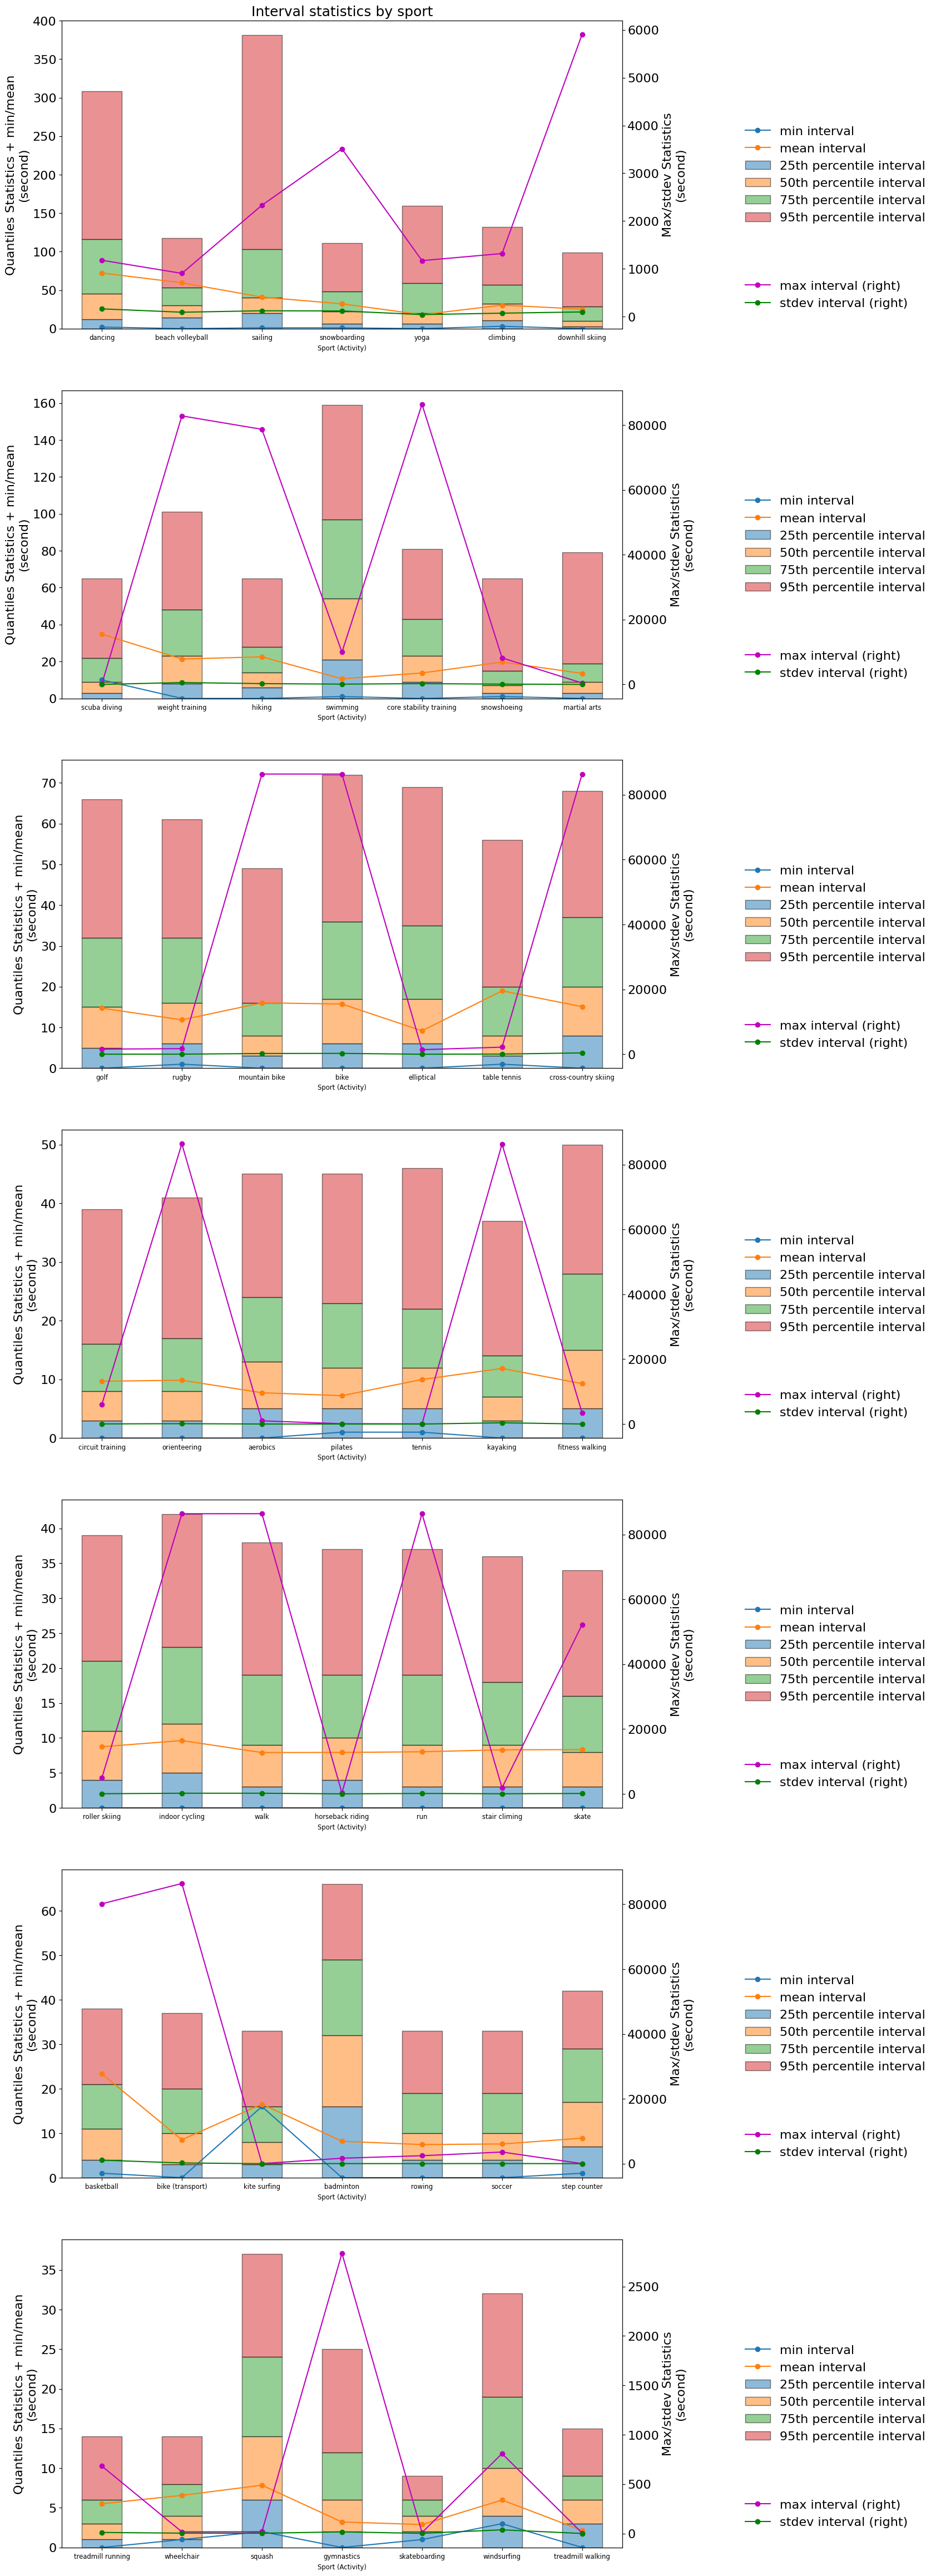

In [21]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

print('\nSummarize statistics of interval sport:')
bar_columns = ['25th percentile interval', '50th percentile interval'
               , '75th percentile interval', '95th percentile interval']
line_columns1 = ['min interval', 'mean interval'] 
line_columns2 = ['max interval', 'stdev interval'] 
interval_statistic_df = interval_statistic_df.sort_values(
    by='95th percentile interval', ascending=False
)
figsize=(13, 59)
fig, axs = plt.subplots(nrows=7, figsize=figsize)

d = axs[0].set_title('Interval statistics by sport', fontsize=18)
for i in range (7):
    interval_statistic_sub_df = interval_statistic_df.iloc[i*7:i*7+7,]
    #interval_statistic_sub_df
    plot1 = interval_statistic_sub_df[['sport'] + bar_columns] \
        .groupby(['sport']).agg(np.mean).plot(
        kind='bar', stacked=True, grid=False, alpha=0.5, edgecolor='black', ax=axs[i], 
    )
    plot2 = interval_statistic_sub_df[['sport'] + line_columns1].plot(x='sport', ax=axs[i], marker='o')
    ax2 = axs[i].twinx()
    plot3 = interval_statistic_sub_df[['sport'] + line_columns2].plot( x='sport', ax=ax2, marker='o', color=['m', 'g'])
    a = axs[i].legend(loc='center left', fontsize=16, bbox_to_anchor=(1.2, 0.5), frameon=False)
    a = ax2.legend(  labels=['max interval (right)', 'stdev interval (right)']
                   , loc="center left", fontsize=16, bbox_to_anchor=(1.2, 0.11), frameon=False)
    b = axs[i].set_xticklabels(interval_statistic_sub_df['sport'],rotation = 'horizontal', fontsize='small')
    c = axs[i].set_xlabel('Sport (Activity)', fontsize='small');
    d = axs[i].set_ylabel('Quantiles Statistics + min/mean\n(second)', fontsize=16);
    e = ax2.set_ylabel('Max/stdev Statistics\n(second)', fontsize=16)
    for tick in axs[i].yaxis.get_major_ticks():
        a = tick.label1.set_fontsize(16) 
    ax2.tick_params(axis='y', labelsize=16)
    b = plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=True)

plt.subplots_adjust(hspace=0.2)

plt.show()